# Comparison of Portfolio Optimisation Techniques - Monte Carlo vs SLSQP vs Bayesian

## Goal

Given a basket of assets, how would you allocation your capital across the different assets to maximize returns and minimize risk? This problem can be seen as a classic optimisation problem in data science. In this experiment, I will attempt to compare the performance of three different techniques, Monte Carlo, [Sequential Least SQuares Programming (SLSQP)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html) and [Bayesian Optimisation](https://github.com/fmfn/BayesianOptimization), on a simple [3-Fund Portfolio for investors in Singapore](https://www.firepathlion.com/the-bogleheads-3-fund-portfolio-for-singapore-firewalkers/). 

## TL;DR

Bayesian optimisation is awesome but requires a long time to compute. Also, the following capital allocation for a 3-Fund Portfolio (for Singapore investors) emerged as the optimal allocation:<sup>*</sup> 

- [ABF Singapore Bond Index Fund (A35)](https://sg.finance.yahoo.com/quote/a35.si/) - 58%
- [SPDR Straits Times Index ETF (ES3)](https://sg.finance.yahoo.com/quote/ES3.SI) - 10%
- [iShares Core MSCI World ETF USD (IWDA)](https://sg.finance.yahoo.com/quote/IWDA.L) - 32%

## Required Knowledge

- Sharpe Ratio
- Efficient Frontier
- Capital Allocation Line

P.s. If you like to follow the experiment, there is a short blurb of how to set up at in Annex A of this article below.

## Setting up

I will import data for the 3 funds and perform FX adjustments to IWDA from USD to SGD. I will also use 2% for the risk-free rate as it's the approximated rate for [SGS](https://www.mas.gov.sg/bonds-and-bills/Singapore-Government-Bonds-Information-for-Individuals) and [SSB](https://www.mas.gov.sg/bonds-and-bills/Singapore-Savings-Bonds) Bonds in Singapore.

In [17]:
from quantfolio import Portfolio, Optimizers
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20, 15

In [2]:
names = ["A35","ES3", "IWDA"]
p = Portfolio()
p.rf = 0.02

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(2, "USD")
p.generateReturnsDataframe()

## Monte Carlo Optimisation Using Statistical Model

Monte Carlo methods is just a class of algorithm that rely on random sampling to obtain results. In this experiment, a statistical model of the funds are constructed and simulated instead of performing the actual backtest. This allows us to run much more simulations. 

For this experiment, a total of 10,000 different capital allocations are simulated and plotted on an efficient market frontier. On the frontier, I will also plot out the [Capital Market Line (CML)](https://www.investopedia.com/terms/c/cml.asp) as well as the horizontal risk-free rate line (constant at 0.02).

In [3]:
%%time
monteCarloStatsSimRes = Optimizers.monteCarloStatsOptimizer(p, sims=10000)

CPU times: user 30.6 s, sys: 10.3 ms, total: 30.6 s
Wall time: 30.6 s


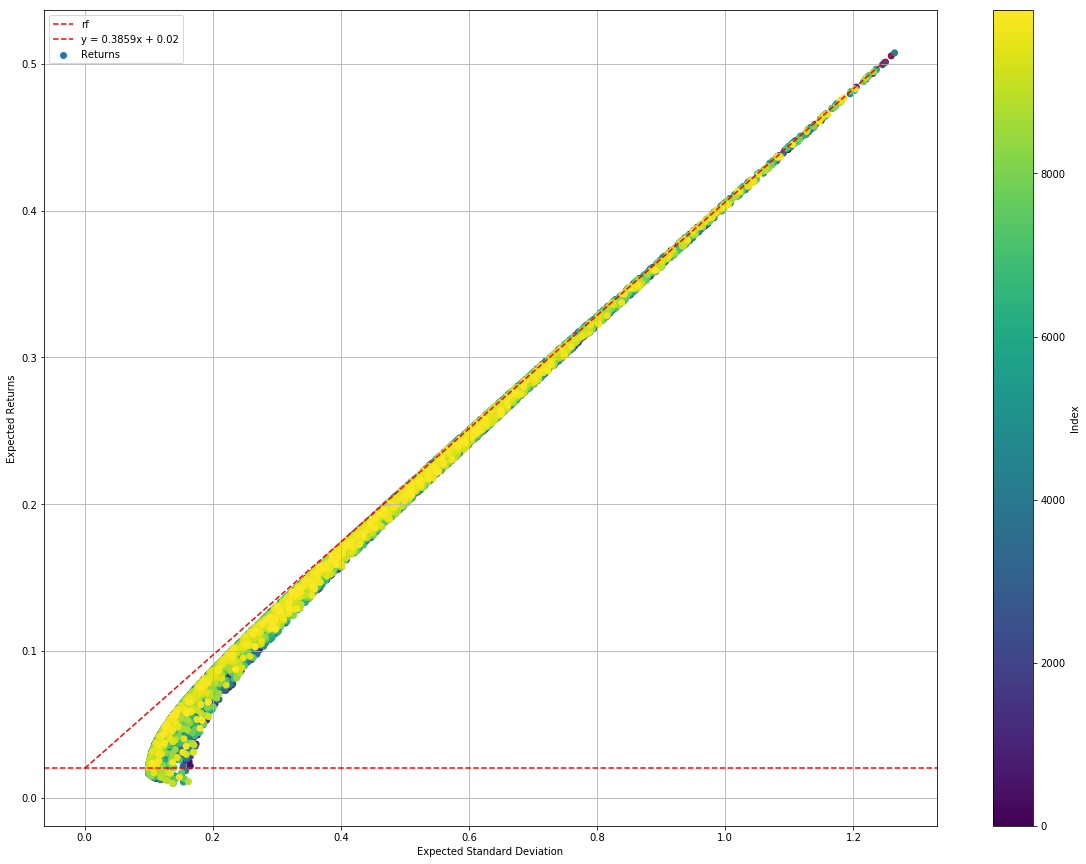

In [18]:
monteCarloStatsSimRes.plotEfficientFrontier()

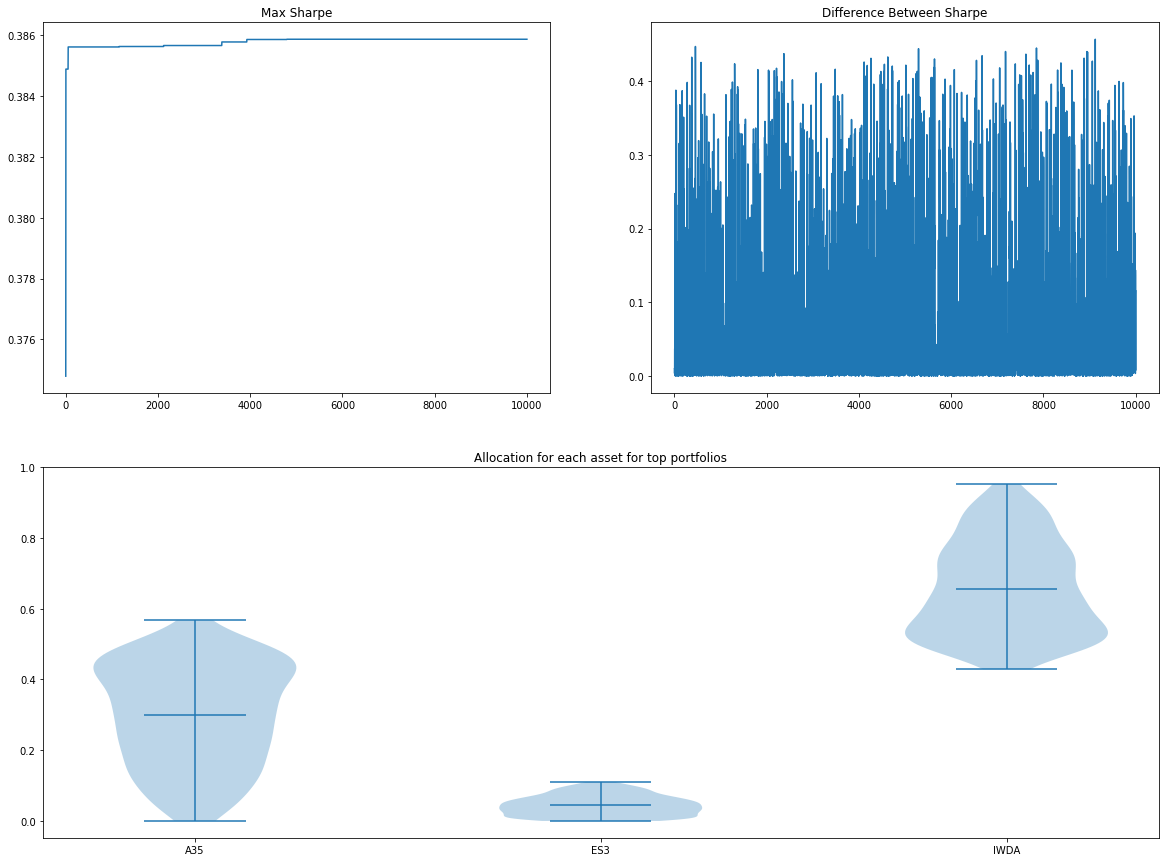

In [19]:
monteCarloStatsSimRes.plotConvergence()

In [6]:
monteCarloStatsSimRes.optimisedWeights()

Sharpe     0.385864
Returns    0.398822
Std        0.981752
A35        0.259819
ES3        0.000747
IWDA       0.739434
Name: 4795, dtype: float64

### Evaluation of Monte Carlo Method

We can see that the simulation is relatively fast, taking only 30 seconds to compute 10,000 simulations. The simulation also gives a pretty [textbook-style efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier) - definitely something impressive to show customers and managers!

Looking at the second graph you can see that there is no convergence as the distance between the Sharpe ratio doesn't drop as we run more simulations. In fact, from the first graph of Max Sharpe vs No. Simulations, we can see that it has found the current portfolio shortly after the 4000th run. That said, we have little confidence that the point with highest sharpe is the global optimum. 

The third graph select a subset of the top 10 percentile of best performing asset allocations (1,000 out of 10,000 sims) and plot the allocations for each of the fund. This gives an idea if there is a consensus (or stability) of the optimal asset allocation. The more varied the allocation, the less sure we are about allocating that percentage of our capital to that fund. 

Pros

- No upkeep for [darts-throwing monkeys](https://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/)
- Relatively fast (~10s for 10,000 sims)
- Less risk of overfitting (as we are using statistical model)

Cons

- No convergence, not even local minima. We can't be too sure how many simulations to run
- Statistical model may not represent how the asset interact with one another
- Randomised allocations may not explore the edge case capital allocation (ie. 0 or 100% to a single asset)


## Sequential Least SQuares Programming (SLSQP) using Statistical Model

SLSQP is an implementation of a class of [Sequential Quadratic Programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming) algorithms. It is useful in this context as the capital allocations for the funds is a class of [constraint satisfaction problem](https://en.wikipedia.org/wiki/Constraint_satisfaction_problem) - the total ratio of all the funds should add up to 1. 

For this experiment we will use the `scipy.minimize(method=’SLSQP’)` method to obtain the optimal capital allocation.

In [7]:
%%time
slsqpStatsSimRes = Optimizers.slsqpStatsOptimizer(p)

CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 219 ms


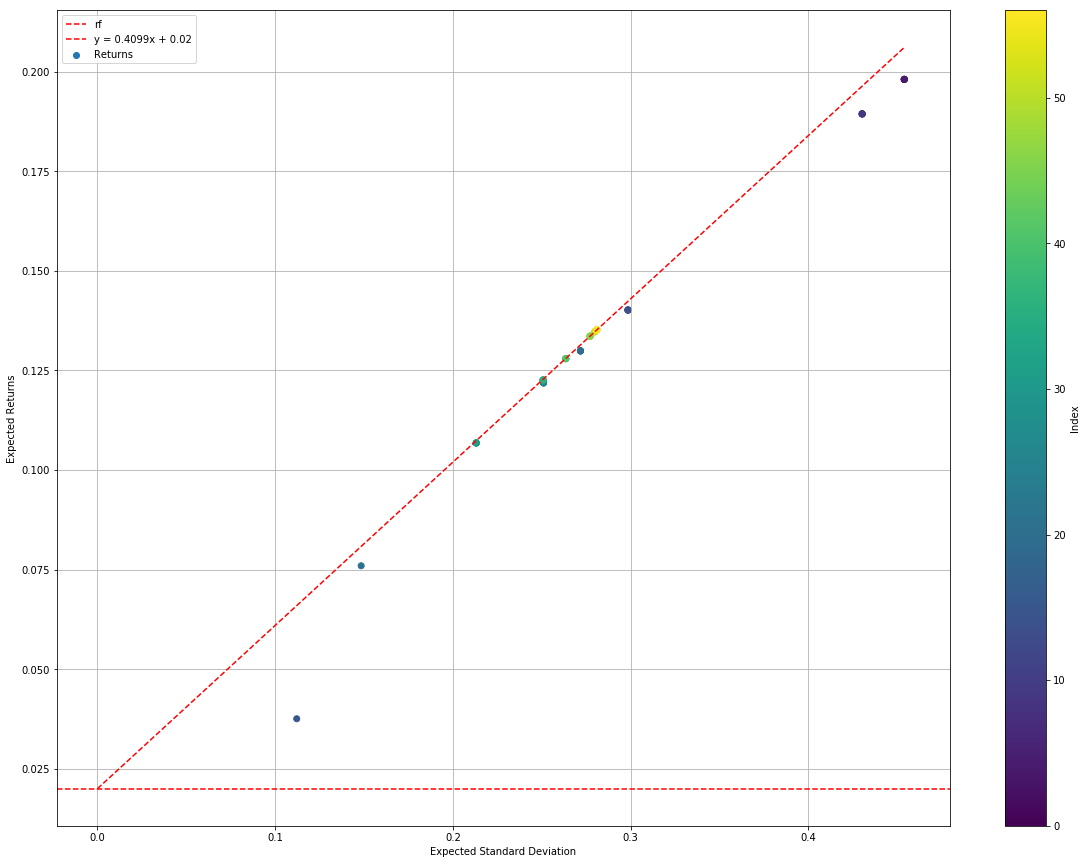

In [20]:
slsqpStatsSimRes.plotEfficientFrontier()

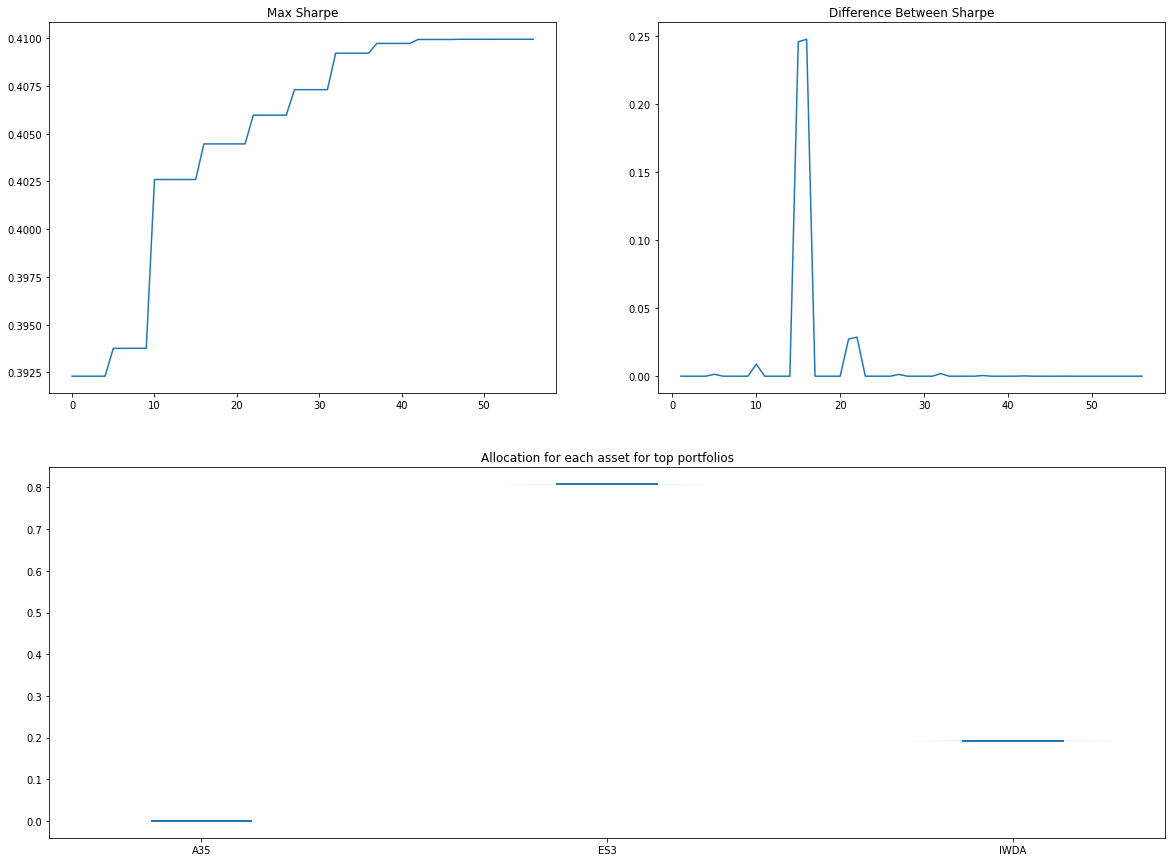

In [21]:
slsqpStatsSimRes.plotConvergence()

In [10]:
slsqpStatsSimRes.optimisedWeights()

Sharpe     0.409949
Returns    0.135174
Std        0.280946
A35        0.000000
ES3        0.807427
IWDA       0.192573
Name: 56, dtype: float64

### Evaluation of SLSQP Method

If Monte Carlo is fast, this SLSQP is blazing fast. We can see that the algorithm found an optimal solution (with higher sharpe than Monte Carlo) in 220 ms and less than 60 simulations. 

From the first graph we can see that the Max Sharpe much faster than that in Monte Carlo method.

In the second, we can see the results converging when the difference of Sharpe between the subsequent tests tends to zero towards the end. 

In the final graph, we can see that the algorithm is almost certain of it's finding. It's almost as though it doesn't need an [investment disclaimer](https://www.disclaimertemplate.net/investment-disclaimers/).

Pros

- Blazing fast (~200ms)
- Local minima results
- Could be very right

Cons

- Statistical model may not represent how the asset interact with one another
- [Optimal capital allocation may not be global minima (depends on initial points)](https://stackoverflow.com/questions/52438263/scipy-optimize-gets-trapped-in-local-minima-what-can-i-do)
- Limited to a very small space of the entire result space
- Could be very wrong

## Bayesian Optimisation using Backtest

Bayesian optimisation makes use of [Bayesian inferences](https://en.wikipedia.org/wiki/Bayesian_inference) to update the probability of hypothesis (in this case, the right capital allocation) when more information becomes available (in this case, the backtest results). In general Bayesian Optimisation is a great technique for hyperparameter tuning in data science/machine learning algorithms as they are great for [cost functions that are slow to evaluate](https://stats.stackexchange.com/questions/193306/optimization-when-cost-function-slow-to-evaluate)! 

Since bayesian optimisation algorithm can take any black-box functions, even non-differentiable ones, unlike SLSQP, we can run use the Sharpe results from actual backtests as the cost function. 

In this case, we will use the following default backtest parameters:

- Rebalance strategy
- 30 days between rebalancing the portfolio
- Backtest between the period where data is present for all assets

Also, since the backtest function is a slow function, we will only run 100 simulations.

In [26]:
%%time
bayesianRes = Optimizers.bayesianOptimizer(p, sims=100)

CPU times: user 12min 7s, sys: 9.33 s, total: 12min 16s
Wall time: 9min 22s


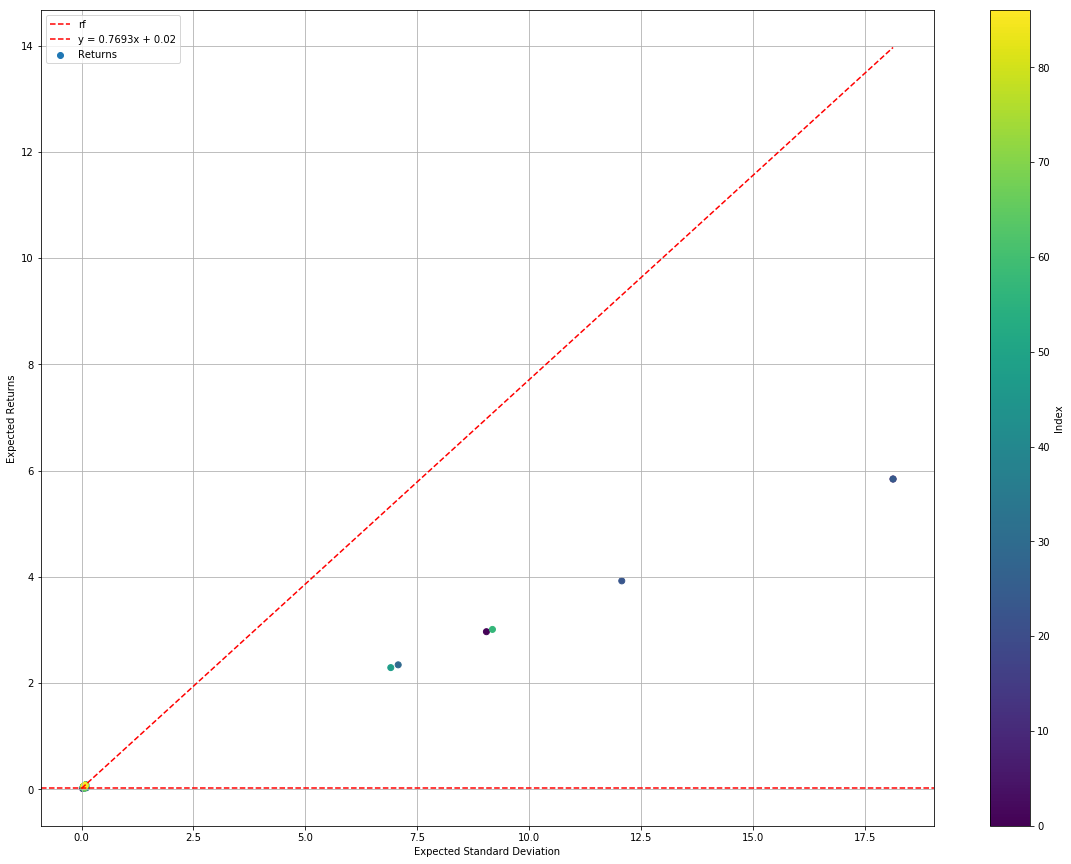

In [27]:
bayesianRes.plotEfficientFrontier()

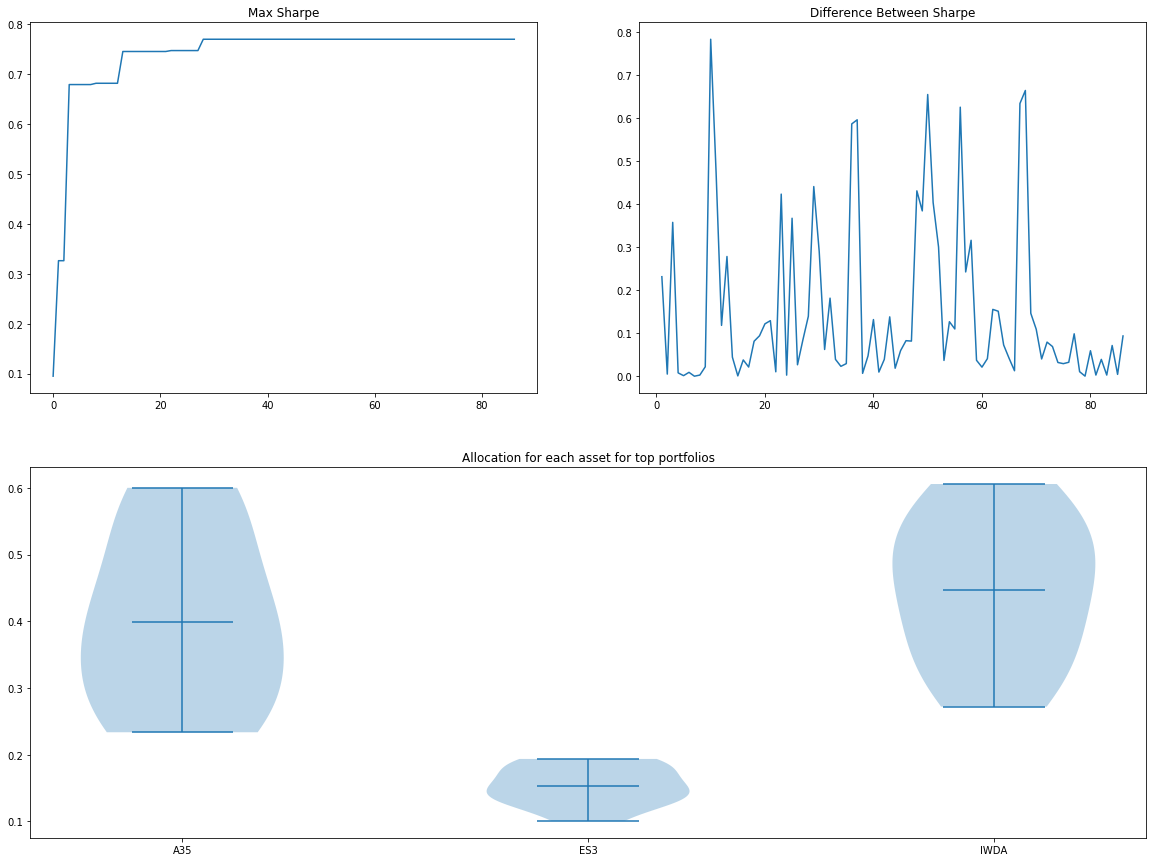

In [28]:
bayesianRes.plotConvergence()

In [29]:
bayesianRes.optimisedWeights()

Sharpe     0.769310
Returns    0.058096
Std        0.049520
A35        0.577516
ES3        0.100814
IWDA       0.321670
Name: 28, dtype: float64

### Evaluation of Bayesian Optimisation Method

We can immediately see that the algorithm takes very long to compute, using > 12 minutes for 100 simulations. Definitely not an algorithm you will like to run in front of your clients. Also, because the backtest is using real data, it also finds the edge cases where standard deviation and sharpe are very far out. You can see there exist an allocation that has close to 600% returns with standard deviation exceeding 1750%. 

Pros
- Real backtest!
- More confidence of results
- Does not use an over generalised statistical model

Cons 
- Slow to converge when number of assets grows (https://www.quora.com/What-are-the-shortcomings-of-Bayesian-optimization-When-should-I-not-use-Bayesian-Optimization-on-a-problem)
- Overfitting
- Historical performance are bad indicators of future performance

## Overall Evaluation

From the 3 experiments above, we obtain 3 set of capital allocation that each algorithm thought to be the optimal strategy. I will now backtest the three strategy and compare them. For easy reference the allocation is summarised in the table below:

| Algorithm   | A35 | ES3 | IWDA |
|-------------|-----|-----|------|
| Monte Carlo | 26% | 0%  | 74%  |
| SLSQP       | 0%  | 81% | 19%  |
| Bayesian    | 58% | 10% | 32%  |

In [31]:
# Monte Carlo Method
p.backtest([0.26, 0, 0.74])

({'dateStart': Timestamp('2009-10-12 00:00:00'),
  'dateEnd': Timestamp('2019-06-13 00:00:00'),
  'days': 3531,
  'valueStart': 100000.0,
  'valueEnd': 12821483.766503,
  'sharpe': 0.32294640895072263,
  'drawdown': 0.3218880079701767,
  'drawdownPeriod': 3,
  'moneydown': 41404.093500001356,
  'maxDrawdown': 24.663639998553524,
  'maxDrawdownPeriod': 731,
  'maxMoneydown': 1915987.0816189982,
  'averageReturns': 4.3486632227292725,
  'standardDeviation': 13.403658014942565,
  'positiveYears': 9,
  'negativeYears': 2,
  'noChangeYears': 0,
  'bestYearReturns': 46.73319437483667,
  'worstYearReturns': -0.053266823539374286},
 <function quantfolio.Portfolio.Portfolio.backtest.<locals>.plot()>)

In [32]:
# SLSQP Method
p.backtest([0, 0.81, 0.19])

({'dateStart': Timestamp('2009-10-12 00:00:00'),
  'dateEnd': Timestamp('2019-06-13 00:00:00'),
  'days': 3531,
  'valueStart': 100000.0,
  'valueEnd': 172662.299007433,
  'sharpe': 0.3926532440034988,
  'drawdown': 2.3608481944519752,
  'drawdownPeriod': 33,
  'moneydown': 4174.856800000009,
  'maxDrawdown': 21.57360770516007,
  'maxDrawdownPeriod': 527,
  'maxMoneydown': 31378.046125000008,
  'averageReturns': 0.05488867216588282,
  'standardDeviation': 0.08885364554780532,
  'positiveYears': 8,
  'negativeYears': 3,
  'noChangeYears': 0,
  'bestYearReturns': 0.14679042213172244,
  'worstYearReturns': -0.1397738798835123},
 <function quantfolio.Portfolio.Portfolio.backtest.<locals>.plot()>)

In [34]:
# Bayesian Method
p.backtest([0.58, 0.10, 0.32])

({'dateStart': Timestamp('2009-10-12 00:00:00'),
  'dateEnd': Timestamp('2019-06-13 00:00:00'),
  'days': 3531,
  'valueStart': 100000.0,
  'valueEnd': 183943.95276198,
  'sharpe': 0.7699201177900674,
  'drawdown': 0.0,
  'drawdownPeriod': 0,
  'moneydown': 0.0,
  'maxDrawdown': 9.410252141245058,
  'maxDrawdownPeriod': 334,
  'maxMoneydown': 14910.591398999968,
  'averageReturns': 0.05810256208778401,
  'standardDeviation': 0.04948898100903157,
  'positiveYears': 9,
  'negativeYears': 2,
  'noChangeYears': 0,
  'bestYearReturns': 0.16939233516950258,
  'worstYearReturns': -0.008053366155367225},
 <function quantfolio.Portfolio.Portfolio.backtest.<locals>.plot()>)

### Results summary

Summarising the backtest results we see the following table: 

| Algorithm   | Sharpe | Ret   | Std   | Max Drawdown |
|-------------|--------|-------|-------|--------------|
| Monte Carlo | 0.32   | 4.34  | 13.4  | 24.66        |
| SLSQP       | 0.39   | 0.055 | 0.088 | 21.57        |
| Bayesian    | 0.77   | 0.058 | 0.049 | 9.4          |

Some interesting observations are: 
1. Monte carlo method found an allocation that generates an average of 434% returns. In the simulation, you will get 12.8m by investing 100k for 10 years! However the risk is also very high at 13,400%. In another world, you might have lost all 100k... Also, the max drawdown shows that at one point you will lose more than 24% of your portfolio before recovering (over 2 years). This strategy may not necessary be the average retail investor...
2. SLSQP method found an allocation that generates an average of 5.5% returns, with 8.8% standard deviation. This seemed like a viable allocation.
3. Bayesian method found an allocation that generates an average of 5.8% returns, with only 4.9% standard deviation. Amongst the 3, this is the only allocation that has higher return compared to standard deviation. Evaluating the overall performance, it seemed like the most sane allocation of funds for a retail investor.  

Looking at the above results, I would choose the Bayesian method anytime. However, for the keen observers, you will notice a problem with the evaluation where we are using in-sample testing each time. This means that the Bayesian optimiser might have over-fitted it's parameter for the backtest. Further experiment using out-of-sample data or cross-validated model should be performed in the future to address this. 

## To Do
- Simulations for asset in out-of-sample date range
- Time-series cross validation of results
- Check out [LIPO Optimisations](http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html)
- Include Value At Risk (VAR)

## Annex A -Setting Up Experiment

If you would like to follow through the experiement, I've distributed the the `Portfolio` and `Optimizers` module in as the [quantfolio package in PYPI](https://pypi.org/project/quantfolio/). Feel free to install the `quantfolio` package to following along!

To build a `Portfolio` you will need to supply the financial data. You will need to download the historical data from Yahoo Finance (ie. https://sg.finance.yahoo.com/quote/A35.SI/history?p=A35.SI) for the three funds and place them in the `./data` folder with the corresponding names. 

Also, since `IWDA` is denominated in USD, we will adjust for the forex by using the USD/SGD forex data. Yahoo Finance don't seemed to provide a tab for historical data for their FX but the endpoint exists. You may download the forex data using the following link with your Yahoo finance token: `https://query1.finance.yahoo.com/v7/finance/download/SGD%3DX?period1=1199030400&period2=1567267200&interval=1d&events=history&crumb=<YOUR_COOKIE>`. You may get the cookie from the download link for the other 3 assets. 

## References

- https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0
- http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html
- https://www.quantopian.com/posts/9-mistakes-quants-make-that-cause-backtests-to-lie
- https://medium.com/quantsketch/backtesters-the-good-the-bad-and-the-money-f0560f2e8ea5
- https://awealthofcommonsense.com/2017/01/10-things-you-cant-learn-from-a-backtest/
- https://portfoliocharts.com/


## Disclaimer

<sup>*</sup> Standard investment disclaimers applies, see [this](https://www.disclaimertemplate.net/investment-disclaimers/). Simply put, "I'm not responsible for whatever financial decisions you make. Investing is risky and if you choose to do it, you're on their own if something goes wrong" 